# <a id='toc1_'></a>[Liabilities in asset management](#toc0_)
4th week, 1st section, Introduction to Portfolio Construction and Analysis with Python.
Vijay Vaidyanathan & Lionel Martellini.  
Notes and code written by Benoît MARION.

**Table of contents**<a id='toc0_'></a>    
- [Liabilities in asset management](#toc1_)    
  - [Lecture 1 - From Asset Management to Asset-Liability Management](#toc1_1_)    
  - [Lecture 2 - Liability hedging portfolios](#toc1_2_)    
  - [Lecture 3 - Liabiliy-driven investing](#toc1_3_)    
  - [Lab 1 - Present values of liabilities and funding ratio](#toc1_4_)    
    - [Imports](#toc1_4_1_)    
    - [Discount function & present value](#toc1_4_2_)    
    - [Funding ratio](#toc1_4_3_)    
  - [Lab 2 - CIR Model and cash vs ZC bonds](#toc1_5_)    
    - [Imports](#toc1_5_1_)    
    - [Short rates and annualized rates](#toc1_5_2_)    
    - [CIR model](#toc1_5_3_)    
    - [Pricing of a zero-coupon bond under CIR model](#toc1_5_4_)    
    - [Cash vs ZC bonds](#toc1_5_5_)    
      - [Variability of assets](#toc1_5_5_1_)    
      - [Variability of funding ratio](#toc1_5_5_2_)    
      - [Comparison of terminal funding ration](#toc1_5_5_3_)    
  - [Lab 3- Facing liabilities with duration matching](#toc1_6_)    
    - [Imports](#toc1_6_1_)    
    - [Effect of interest rates on bond prices](#toc1_6_2_)    
    - [Macaulay Duration](#toc1_6_3_)    
    - [Duration matching](#toc1_6_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Lecture 1 - From Asset Management to Asset-Liability Management](#toc0_)

Huge financial crisis often generate gigantic losses for pension funds portfolio for 2 interconnected reasons:
- reduction of the equity value
- CB decreases the interest rate $\rightarrow$ increase in liability value  
 
To face those issues, the concept asset-liability management has emerged. It takes into account the assets values relatively to the liability side.

## <a id='toc1_2_'></a>[Lecture 2 - Liability hedging portfolios](#toc0_)

Investors main concern is an unexpected increase of the present value of their liabilities relative to their assets.   
To hedge against that risk, invertors use portfolios that  goes int the same direction as their future liabilities (LHP or GHP).  
To implement that, investors often implement cash-flow matching or factor exposure matching approaches.

## <a id='toc1_3_'></a>[Lecture 3 - Liabiliy-driven investing](#toc0_)

There is a form schizophrenia in asset managment: the poursuit of performance and the fear of risk. 

To solve that apparent disagreement, investor often base their strategy on 2 different portfolios:
- a performance-seeking portfolio
- a liability-hedging portfolio

## <a id='toc1_4_'></a>[Lab 1 - Present values of liabilities and funding ratio](#toc0_)

As it is common to do in fixed income, to calculate present value of liabilities we need to use the following formula:
$$ PV(L)=\sum_{i=1}^k B(t_i)L_i$$ 
where $B(t_i)$ is the actualization function at time $t_i$ :
$ B(t)=\frac{1}{(1+r)^t}$

### <a id='toc1_4_1_'></a>[Imports](#toc0_)

In [3]:
import add_doc_path
import finance_pkg.Edhec_risk_kit as erk
import pandas as pd 
import numpy as np

### <a id='toc1_4_2_'></a>[Discount function & present value](#toc0_)

In [4]:
def discount(t,r):
    """Gives the discount coefficient for t periods at r interest

    Args:
        t (int): periods
        r (float): discount rate (interest)

    Returns:
        float: present value of a dollar obtained at period t
    """
    return (1+r)**(-t)

In [5]:
discount(10,.03)

0.7440939148967249

In [6]:
def pv(l,r):
    """
    Computes the present value for a sequence of liabilities 
    Args:
        l (pd.Series or pd.DataFrame): amount of each liability indexed by time
        r (float): discount rate

    Returns:
        float: present value of the sequence
    """
    dates=l.index
    discounts=discount(dates,r)
    return (discounts*l).sum()

In [7]:
liabilities=pd.Series(data=[1,1.5,2,2.5],index=[3,3.5,4,4.5])
pv(liabilities,.03)

6.233320315080045

6,23 is the amount i would have to invest at the interest rate today in order to meet my liabilities in the future.

### <a id='toc1_4_3_'></a>[Funding ratio](#toc0_)

In [41]:
def funding_ratio(a, l,r):
    """
    Computes the funding ratio given assets, liabilities and r
    Args:
        a (float): value of the assets in possession
        l (pd.Series or pd.DataFrame): amount of each liability indexed by time
        r (float): discount rate
    Returns:
        float: funding ratio
    """
    return a/pv(l,r)

As we can see below, the level of interest rates impacts clearly our funding ratio:
- if it becomes lower, the liabilities we have become more expensive: we have to invest more money today at the discount rate too meet our liability level.
- on the opposite side, the liabilities we have become less expensive in terms of present value

In [29]:
import ipywidgets as widgets
import IPython.display as display

In [43]:
def show_funding_ratio(assets, r):
    fr=funding_ratio(assets,liabilities, r)
    print(f'{fr*100:.2f}')

103.74
86.49
None None


In [45]:
print(show_funding_ratio(5,.1),show_funding_ratio(5,.05))

103.74
86.49
None None


In [44]:
print(show_funding_ratio(4,.1),show_funding_ratio(6,.1),show_funding_ratio(8,.1))

82.99
124.48
165.98
None None None


## <a id='toc1_5_'></a>[Lab 2 - CIR Model and cash vs ZC bonds](#toc0_)

The objective is to understand how beahves a portfolio in case of interest rate change.   

The Cox Ingersoll Ross model describes the dynamics of interest rates, and is an extension of the popular Vasicek model to prevent negetive interest rates (term $\sqrt{r_t}): $$ dr_t=a(b-r_t)dt+\sigma\sqrt {r_t}dW_t $$

### <a id='toc1_5_1_'></a>[Imports](#toc0_)

In [1]:
import numpy as np
import pandas as pd

import add_doc_path
import finance_pkg.Edhec_risk_kit as erk

### <a id='toc1_5_2_'></a>[Short rates and annualized rates](#toc0_)

If interest rates are given on a monthly or daily basis, there is a compounding effect and the annualized rate is necesarelly way higher than the montly or daily rate. As the frequency of the interest becomes large, the annualized rate tends to $e^{r_{inst}} -1$.

In [2]:
def inst_to_ann(r):
    """
    Converts short term rate to annualized
    Args:
        r (float): instant rate
    Returns:
        floar: annualized rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converts annualized rate to short term
    Args:
        r (float): annualized rate
    Returns:
        float: instant rate
    """
    return np.log1p(r)

### <a id='toc1_5_3_'></a>[CIR model](#toc0_)

The CIR model describes the evolution of interest rate on the short term and is based on a mean reversing process. 

In [4]:
def cir(n_years=10,n_scenarios=1,a=.05,b=.03,sigma=.05,steps_per_year=12,r_0=None):
    """
    Implements the CIR model for interest rate
    Args:
        n_years (int, optional): _description_. Defaults to 10.
        n_scenarios (int, optional): _description_. Defaults to 1.
        a (float, optional): speed of the mean reversion. Defaults to .05.
        b (float, optional): long term mean. Defaults to .03.
        sigma (float, optional): volatility. Defaults to .05.
        steps_per_year (int, optional): _description_. Defaults to 12.
        r_0 (_type_, optional): iniatial value. Defaults to None.
    Returns:
        float: instant rate
    """
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0)
    dt=1/steps_per_year
    
    num_steps=int(n_years*steps_per_year)+1
    shock=np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))
    
    rates=np.empty_like(shock)
    rates[0]=r_0
    
    for step in range(1,num_steps):
        r_t=rates[step-1]
        d_r_t=a*(b-r_t)*dt+sigma*np.sqrt(r_t)*shock[step]
        rates[step]=abs(r_t+d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps))

<AxesSubplot: >

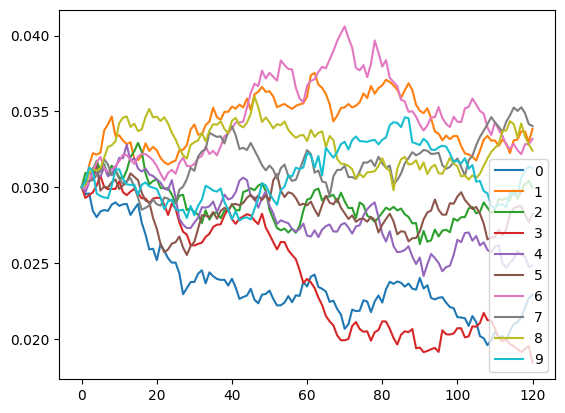

In [9]:
cir(n_scenarios=10,sigma=.01).plot()

### <a id='toc1_5_4_'></a>[Pricing of a zero-coupon bond under CIR model](#toc0_)

Under the no-arbitrage assumption, a discount bond may be priced in the Vasicek model 
(cf wikipedia: https://en.wikipedia.org/wiki/Vasicek_model).

In [20]:
import math

def cir(n_years=10,n_scenarios=1,a=.05,b=.03,sigma=.05,steps_per_year=12,r_0=None):
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0)
    dt=1/steps_per_year
    num_steps=int(n_years*steps_per_year)+1
    
    shock=np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))
    rates=np.empty_like(shock)
    rates[0]=r_0
    
    ## for price generation
    h=math.sqrt(a**2+2*sigma**2)
    prices=np.empty_like(shock)
      
    def price(ttm,r):
        _A=((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B=(2*(math.exp(h*ttm)-1))/(2*h+(h+a)*(math.exp(h*ttm)-1))
        _P=_A*np.exp(-_B*r)
        return _P
    prices[0]=price(n_years,r_0)
    
    for step in range(1,num_steps):
        r_t=rates[step-1]
        d_r_t=a*(b-r_t)*dt+sigma*np.sqrt(r_t)*shock[step]
        rates[step]=abs(r_t+d_r_t)
        prices[step]=price(n_years-step*dt,rates[step])
        
    rates=pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps))
    prices=pd.DataFrame(data=prices,index=range(num_steps))
    
    return rates,prices

In [21]:
def show_cir_prices(r_0=.03,a=.5,b=.03,sigma=.05,n_scenarios=5):
    cir(r_0=r_0,a=a,b=b,sigma=sigma,n_scenarios=n_scenarios)[1].plot(legend=False,figsize=(12,5))

In [24]:
import ipywidgets as widgets
from IPython.display import display
controls=widgets.interactive(show_cir_prices,
                             r_0=(0,.1,.01),
                             a=(0,1,.1),
                             b=(0,.15,.01),
                             sigma=(0.01,.1,.01),
                             n_scenarios=(1,100))

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.1, step=0.01), FloatSlider(value=0.5, d…

As we can see the zero-coupon bond eliminates the risk induced by the variation of liabilities.

### <a id='toc1_5_5_'></a>[Cash vs ZC bonds](#toc0_)

In [44]:
a_0=.75
rates,bond_prices=cir(r_0=.03,b=.03,n_scenarios=10)
liabilities=bond_prices
zc_0=erk.pv(pd.Series(data=[1],index=[10]),r=.03)
n_bonds=a_0/zc_0
av_zc_bonds=n_bonds*bond_prices
av_cash=a_0*(rates/12+1).cumprod()

#### <a id='toc1_5_5_1_'></a>[Variability of assets](#toc0_)

<AxesSubplot: >

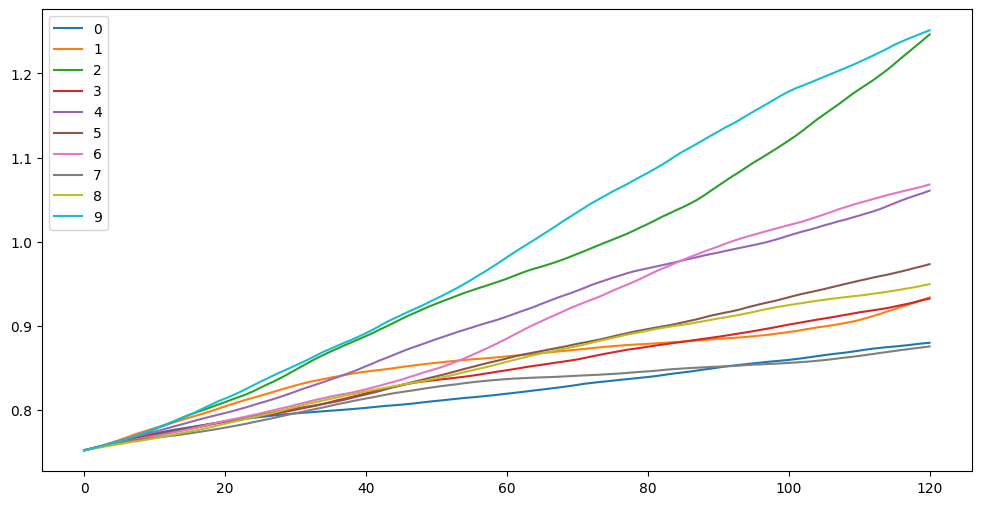

In [45]:
av_cash.plot(figsize=(12,6))

<AxesSubplot: >

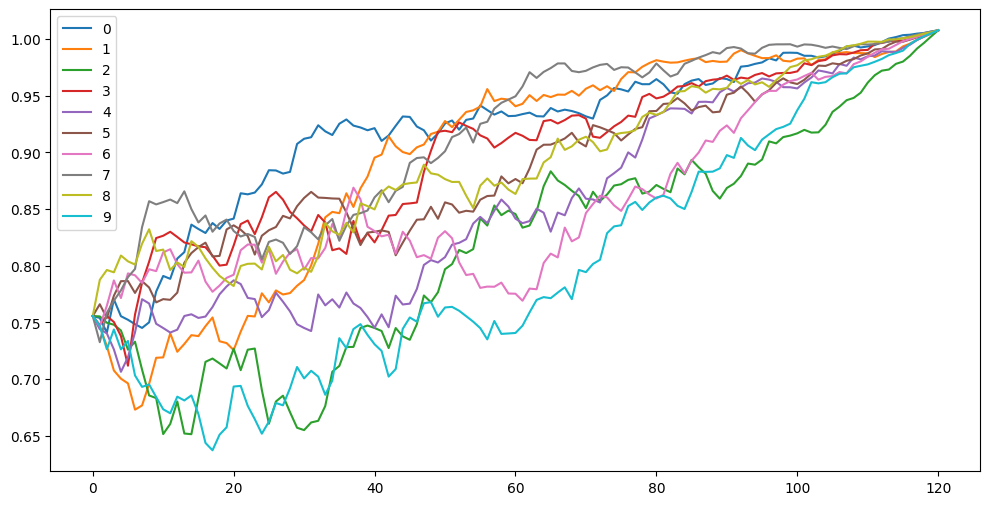

In [46]:
av_zc_bonds.plot(figsize=(12,6))

#### <a id='toc1_5_5_2_'></a>[Variability of funding ratio](#toc0_)

<AxesSubplot: >

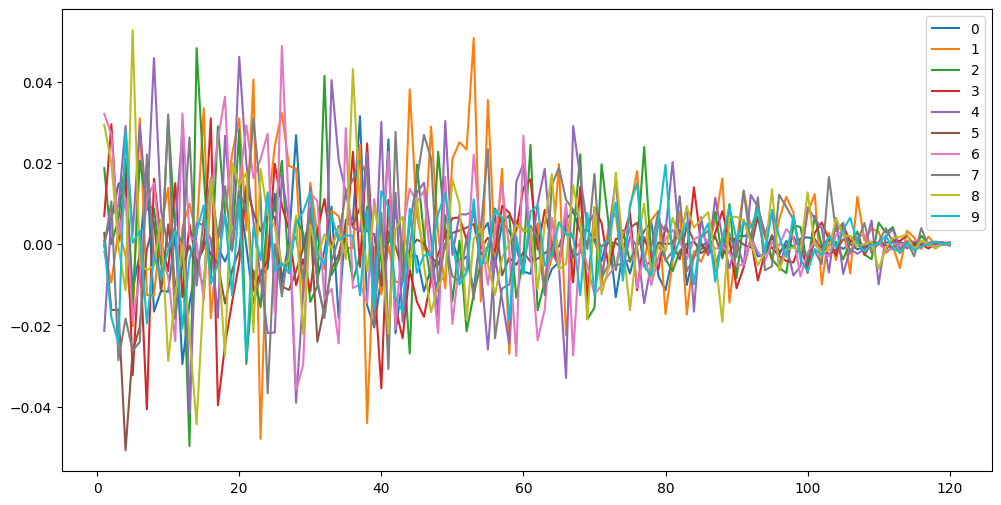

In [43]:
(av_cash/liabilities).pct_change().plot(figsize=(12,6))

<AxesSubplot: >

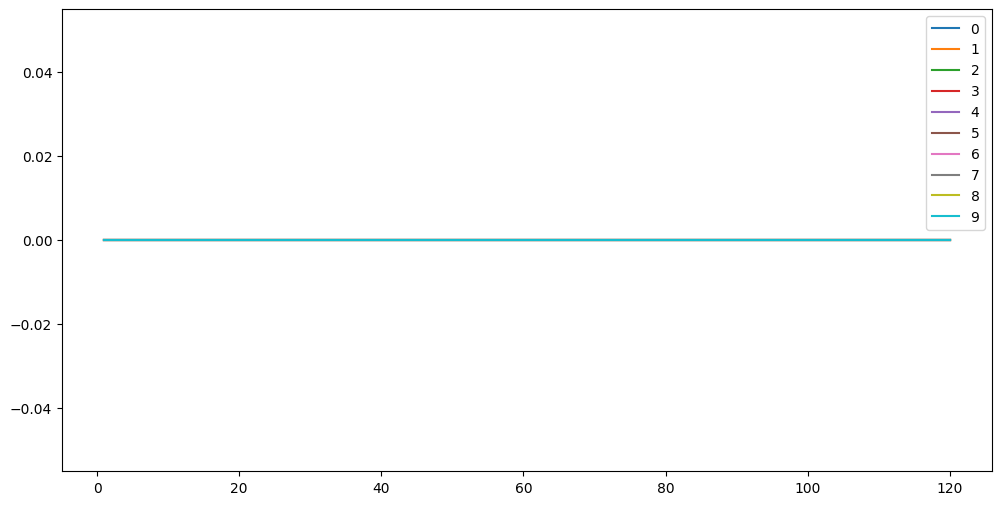

In [47]:
(av_zc_bonds/liabilities).pct_change().plot(figsize=(12,6))

#### <a id='toc1_5_5_3_'></a>[Comparison of terminal funding ration](#toc0_)

In [48]:
a_0=.75
rates,bond_prices=cir(r_0=.03,b=.03,n_scenarios=10000)
liabilities=bond_prices
zc_0=erk.pv(pd.Series(data=[1],index=[10]),r=.03)
n_bonds=a_0/zc_0
av_zc_bonds=n_bonds*bond_prices
av_cash=a_0*(rates/12+1).cumprod()

<AxesSubplot: >

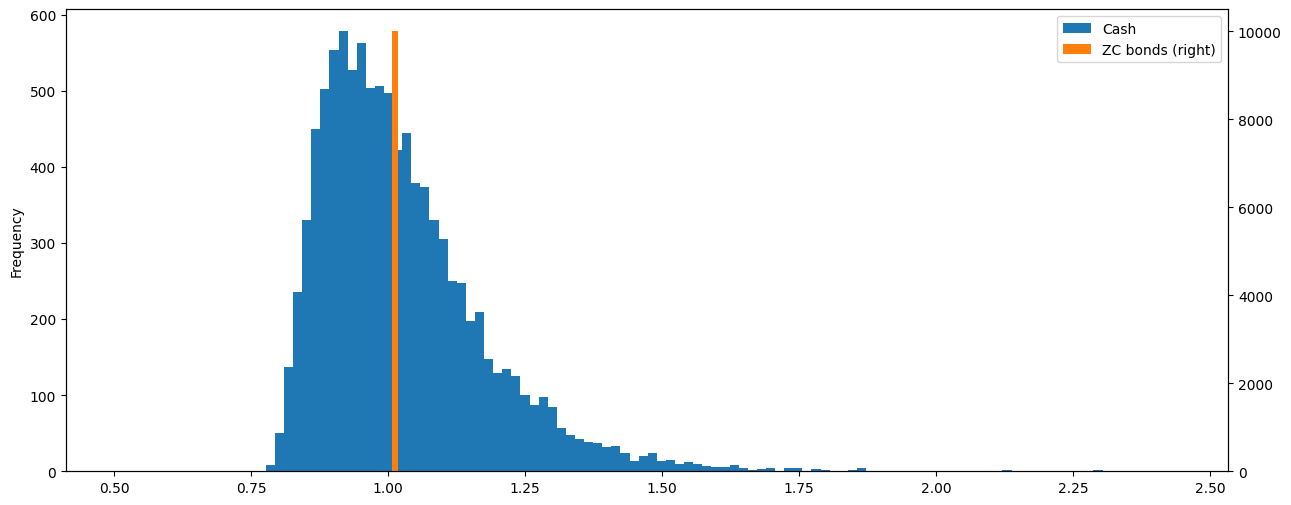

In [50]:
tfr_cash=av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds=av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax=tfr_cash.plot.hist(label="Cash",figsize=(15,6),bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="ZC bonds",bins=100,legend=True,secondary_y=True)

## <a id='toc1_6_'></a>[Lab 3- Facing liabilities with duration matching](#toc0_)

Zero-coupon bonds are not so common on the market and portfolio managers often need products that behave the same way but are built with regular bonds.

### <a id='toc1_6_1_'></a>[Imports](#toc0_)

In [1]:
import numpy as np
import pandas as pd

import add_doc_path
import finance_pkg.Edhec_risk_kit as erk

### <a id='toc1_6_2_'></a>[Effect of interest rates on bond prices](#toc0_)

<AxesSubplot: title={'center': 'Price of a 10y bond in function of discount rate'}>

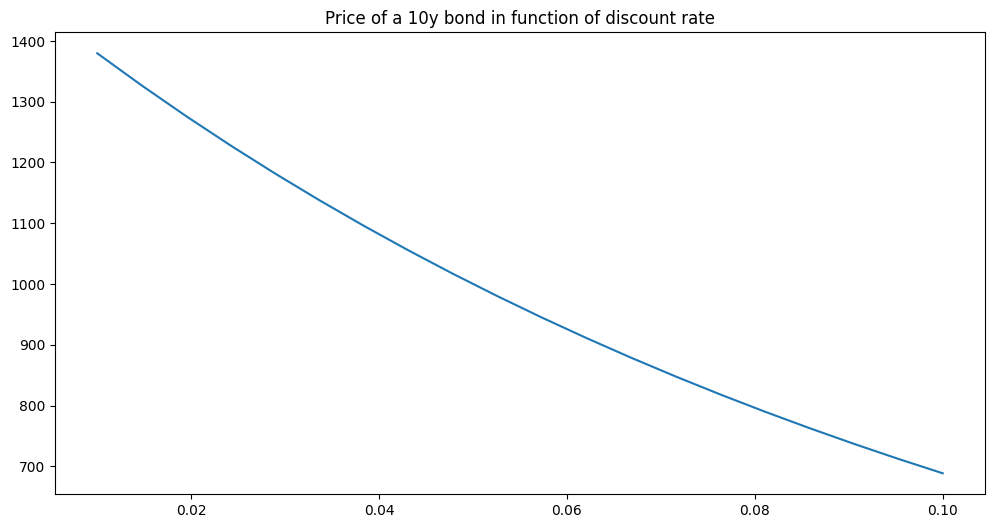

In [2]:
rates=np.linspace(.01,.10,num=20)
prices=[erk.bond_price(10,1000,.05,2,r) for r in rates]
pd.DataFrame(data=prices,index=rates).plot(title="Price of a 10y bond in function of discount rate",
                                           legend=False,
                                           figsize=(12,6))

### <a id='toc1_6_3_'></a>[Macaulay Duration](#toc0_)

We can compute the weighted average number of years that an investor must maintain a position in the bond until the present value of the bond’s cash flows equals the amount paid for the bond. It's called the Macaulay duration.

In [3]:
erk.macaulay_duration(erk.bond_cash_flow(3,1000,.06,2),.06/2)

5.579707187194534

### <a id='toc1_6_4_'></a>[Duration matching](#toc0_)

Let's imagine we have to liabilities in the long run:

In [4]:
liabilities=pd.Series(data=[100000,100000],index=[10,12])
md_l=erk.macaulay_duration(liabilities,.04)
print(md_l)

10.960799385088393


To be sure to face our liabilities we could:
- get 2 ZC bonds of 10 and 12 years maturity
- get 1 ZC bond of 10.96 years maturity
- or match durations with common bonds:

In [5]:
md_10=erk.macaulay_duration(erk.bond_cash_flow(10,1000,.05,1),.04)
md_20=erk.macaulay_duration(erk.bond_cash_flow(20,1000,.05,1),.04)
print(md_10,md_20)

8.190898824083233 13.544718122145921


We just have to find the weight that gives us the liability durations, which we have built in our toolkit.

In [6]:
w_s=erk.match_duration(liabilities,
                   erk.bond_cash_flow(10,1000,.05,1),
                   erk.bond_cash_flow(20,1000,.05,1),
                   discount_rate=.04)

w_s

0.48263092069478974

In [7]:
short_bond=erk.bond_cash_flow(10,1000,.05,1)
long_bond=erk.bond_cash_flow(20,1000,.05,1)
p_short=erk.bond_price(10,1000,.05,1,.04)
p_long=erk.bond_price(20,1000,.05,1,.04)

a_0=130000

p_flows=pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(p_flows,.04)

10.960799385088393

In [9]:
cfr=erk.funding_ratio(p_flows,liabilities,.04)
cfr

0.9998760012192478

<AxesSubplot: title={'center': 'Funding ration with change in interest rates'}>

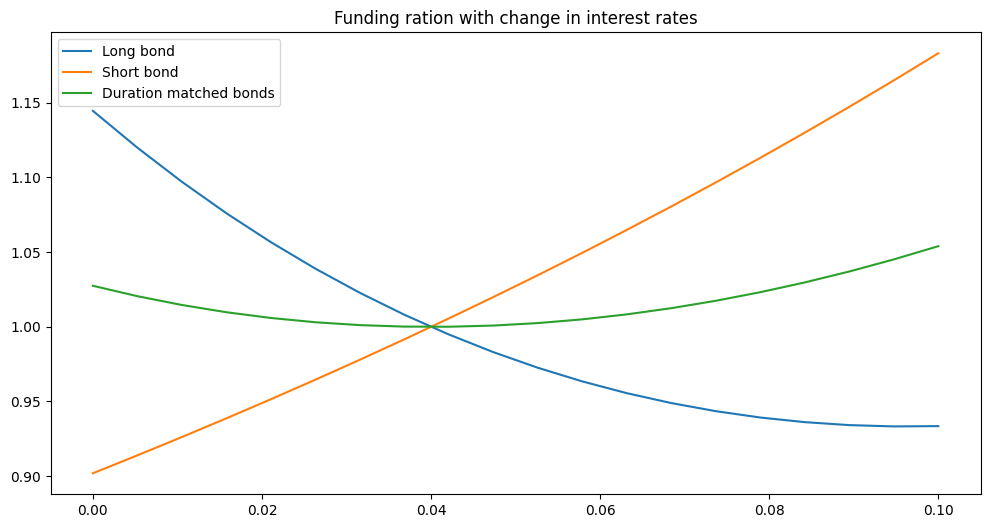

In [13]:
rates=np.linspace(0,.1,20)

sb_assets=a_0*short_bond/p_short
lb_assets=a_0*long_bond/p_long

fr_change=pd.DataFrame({
    "Long bond":[erk.funding_ratio(lb_assets,liabilities,r) for r in rates],
    "Short bond":[erk.funding_ratio(sb_assets,liabilities,r) for r in rates],
    "Duration matched bonds":[erk.funding_ratio(p_flows,liabilities,r) for r in rates]},
    index=rates)

fr_change.plot(title="Funding ration with change in interest rates",figsize=(12,6))

With a proper duration matching, a portfolio can avoid all exposure to change in interest rates without using ZC bonds.